In [1]:
from ppo0 import PPO, Memory, FClayer, WaveNET, plot, ActorCritic
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
import gym_Aircraft

In [2]:
actor_model = torch.load("./Custom_model_fin")
critic_model = torch.load("./Custom_model_fin")
mean = np.load('mean_test.npy')
std = np.load('std_test.npy')

In [3]:
num_final_nodes = critic_model.fin_fc.in_features
critic_model.fin_fc = nn.Linear(num_final_nodes, 1)

In [4]:
num_final_nodes = actor_model.fin_fc.in_features
num_output_nodes = actor_model.fin_fc.out_features
actor_model.fin_fc = nn.Sequential(nn.Linear(num_final_nodes, num_output_nodes), nn.Softmax(dim=-1))

In [5]:
# set angular constants
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

############## Hyperparameters ##############
succeed_coef = 100         # maximum reward when agent avoids collision
collide_coef = -4000        # reward when agent doesn't avoid collision
change_cmd_penalty = -100   # reward when agent changes command values
cmd_penalty = -0.05          # coefficient of penaly on using command
cmd_suit_coef = -50         # coefficient of suitable command
start_cond_coef = 0.7       # coefficient of condition on begining

solved_reward = 100000       # stop training if avg_reward > solved_reward
log_interval = 20          # print avg reward in the interval
max_episodes = 1000000      # max training episodes
max_timesteps = 300         # max timesteps in one episode
n_latent_var = 60           # number of variables in hidden layer
update_timestep = 2000      # update policy every n timesteps
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.999                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
action_maintain_steps = 1    # steps to maintain the action
random_seed = None

# creating environment
experiment_version = 1.24
env_name = "acav-v0"
env = gym.make(env_name)
env.env.__init__(succeed_coef, collide_coef, change_cmd_penalty, cmd_penalty, start_cond_coef, cmd_suit_coef)
render = False

#############################################

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)

memory = Memory()
ppo = PPO(actor_model, critic_model, lr, betas, gamma, K_epochs, eps_clip)
# load weight to transfer knowledges
# ppo.policy_old.load_state_dict(torch.load("PPO_1.2.pth"))

# logging variables
running_reward = 0
avg_length = 0
timestep = 0

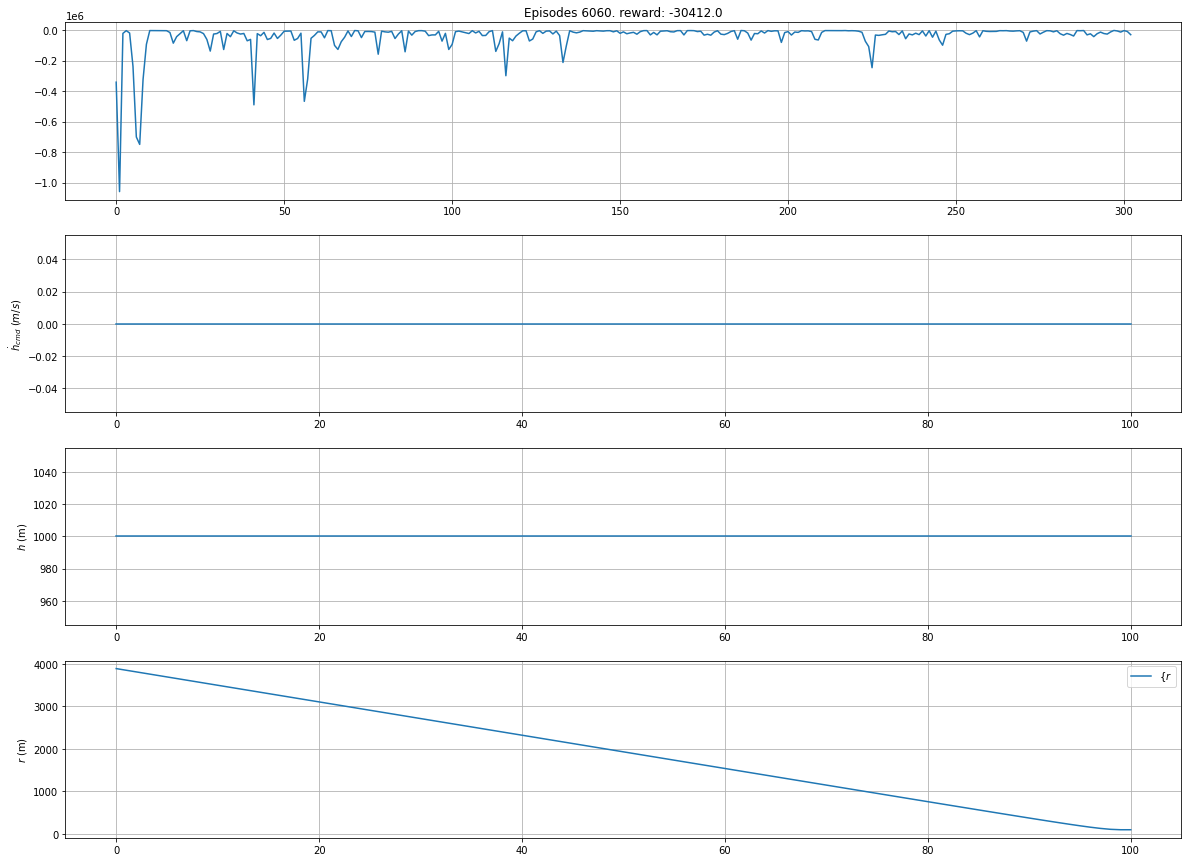

In [ ]:
# initialize lists for print
rewards   = []
total_res=[]

# training loop
for i_episode in range(1, max_episodes+1):
    epi_reward=0
    action_steps = action_maintain_steps
    
    state = env.reset()

    res_list=np.zeros(11)
    
    for t in range(max_timesteps):
        timestep += 1
        state = (state-mean)/std

        # make action maintained
        if action_steps == action_maintain_steps:
            action = ppo.policy_old.act(state, memory)
            action_steps = 0
        else:
            ppo.policy_old.act(state, memory)
            
        # Running policy_old:    
        state, reward, done, info = env.step(action)
        
        # count number of action steps
        action_steps += 1
        
        # save data to print
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=info["info"]
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])

        # Saving reward and is_terminal:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if timestep % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            timestep = 0

        running_reward += reward
        epi_reward += reward
        if render:
            env.render()
        if done:
            res_list=np.delete(res_list,0,0)
            total_res.append(res_list)
            break

    avg_length += t

    # stop training if avg_reward > solved_reward
    if running_reward > (log_interval*solved_reward):
        print("########## Solved! ##########")
        torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(experiment_version))
        break

    # logging
    if i_episode % log_interval == 0:
        avg_length = avg_length/log_interval
        running_reward = running_reward/log_interval
        rewards.append(running_reward)
        plot(i_episode,rewards,total_res)

        print('Episode {} \t avg length: {} \t run_reward: {} \t min_r: {} \t reward: {}'.format(i_episode, avg_length, running_reward,min(total_res[-1][:,1]),epi_reward), end="\r")
        running_reward = 0
        avg_length = 0

In [ ]:
torch.save(ppo.policy.state_dict(), './PPO_{}.pth'.format(experiment_version))

In [ ]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[-1]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

In [ ]:
# trajectory plots

from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()